## GAN starter code
Corresponding tutorial: [https://youtu.be/_pIMdDWK5sc](https://youtu.be/_pIMdDWK5sc)

In [11]:
%pip install pytorch-lightning

In [12]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST, Flowers102

import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torchmetrics.image.fid import FrechetInceptionDistance
from tqdm import tqdm


random_seed = 42
torch.manual_seed(random_seed)

# Optimize for Tensor Cores (A100 GPU) - improves performance
torch.set_float32_matmul_precision('medium')

BATCH_SIZE=32
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

In [13]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [14]:
class FlowersDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data",
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, image_size=64,
                 combine_train_val=True, use_augmentation=True):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.image_size = image_size
        self.combine_train_val = combine_train_val
        self.use_augmentation = use_augmentation

        # Base transform (always applied)
        base_transform = [
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            # normalize to [-1, 1] for GANs
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
        
        # Training transform with augmentation
        if use_augmentation:
            self.train_transform = transforms.Compose([
                transforms.Resize(int(image_size * 1.1)),  # Slightly larger for random crop
                transforms.RandomCrop(image_size),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
        else:
            self.train_transform = transforms.Compose(base_transform)
        
        # Validation/test transform (no augmentation)
        self.val_transform = transforms.Compose(base_transform)

    def prepare_data(self):
        Flowers102(self.data_dir, split="train", download=True)
        Flowers102(self.data_dir, split="val", download=True)
        Flowers102(self.data_dir, split="test", download=True)

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            flowers_train = Flowers102(self.data_dir, split="train",
                                       transform=self.train_transform)
            
            if self.combine_train_val:
                # Combine train and val splits for more training data
                flowers_val = Flowers102(self.data_dir, split="val",
                                         transform=self.train_transform)
                # Combine datasets
                from torch.utils.data import ConcatDataset
                self.flowers_train = ConcatDataset([flowers_train, flowers_val])
                print(f"Combined train+val: {len(self.flowers_train)} images")
                print(f"Batches per epoch: {len(self.flowers_train) // self.batch_size}")
            else:
                self.flowers_train = flowers_train
                self.flowers_val = Flowers102(self.data_dir, split="val",
                                              transform=self.val_transform)
                print(f"Train images: {len(self.flowers_train)}")
                print(f"Batches per epoch: {len(self.flowers_train) // self.batch_size}")

        if stage == "test" or stage is None:
            self.flowers_test = Flowers102(self.data_dir, split="test",
                                           transform=self.val_transform)

    def train_dataloader(self):
        return DataLoader(self.flowers_train, batch_size=self.batch_size,
                          num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        # Disable validation loop - return None to suppress warning
        return None

    def test_dataloader(self):
        return DataLoader(self.flowers_test, batch_size=self.batch_size,
                          num_workers=self.num_workers)

In [15]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self, channels=1, image_size=28):
        super().__init__()
        self.channels = channels
        self.image_size = image_size
        
        # Calculate flattened size after conv layers
        # For 64x64: conv1+pool -> 30x30, conv2+pool -> 13x13
        # For 28x28: conv1+pool -> 12x12, conv2+pool -> 4x4
        if image_size == 64:
            flattened_size = 13 * 13 * 20
        else:  # 28x28
            flattened_size = 4 * 4 * 20
        
        # Simple CNN
        self.conv1 = nn.Conv2d(channels, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(flattened_size, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(x.size(0), -1)  # Use -1 to automatically calculate size
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [16]:
# Generate Fake Data: output like real data
class Generator(nn.Module):
    def __init__(self, latent_dim, channels=1, image_size=28):
        super().__init__()
        self.image_size = image_size
        
        if image_size == 64:
            # For 64x64: start with 4x4, upsample to 8x8, 16x16, 32x32, 64x64
            self.lin1 = nn.Linear(latent_dim, 4*4*512)
            self.ct1 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1)  # 4->8
            self.ct2 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)  # 8->16
            self.ct3 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)   # 16->32
            self.ct4 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)    # 32->64
            self.conv = nn.Conv2d(32, channels, kernel_size=3, padding=1)    # 64->64
        else:  # 28x28
            self.lin1 = nn.Linear(latent_dim, 7*7*64)
            self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2)  # 7->14
            self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2)  # 14->28
            self.ct3 = None
            self.ct4 = None
            self.conv = nn.Conv2d(16, channels, kernel_size=7)  # 28->28

    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        
        if self.image_size == 64:
            x = x.view(-1, 512, 4, 4)
            x = F.relu(self.ct1(x))  # 8x8
            x = F.relu(self.ct2(x))  # 16x16
            x = F.relu(self.ct3(x))  # 32x32
            x = F.relu(self.ct4(x))  # 64x64
            x = torch.tanh(self.conv(x))  # Output in [-1, 1] range
        else:  # 28x28
            x = x.view(-1, 64, 7, 7)
            x = F.relu(self.ct1(x))  # 14x14
            x = F.relu(self.ct2(x))  # 28x28
            x = torch.tanh(self.conv(x))  # Output in [-1, 1] range
        
        return x

In [17]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, channels=1, image_size=28, lr=0.0002):
        super().__init__()
        self.save_hyperparameters()
        
        # Required for multiple optimizers
        self.automatic_optimization = False

        self.generator = Generator(latent_dim=latent_dim, channels=channels, image_size=image_size)
        self.discriminator = Discriminator(channels=channels, image_size=image_size)

        self.validation_z = torch.randn(8, self.hparams.latent_dim)
        self.total_epochs_trained = 0

    def forward(self, z):
        return self.generator(z)
    
    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)
    
    def training_step(self, batch, batch_idx):
        opt_g, opt_d = self.optimizers()
        
        real_imgs, _ = batch
        z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(real_imgs)

        # Train Generator (every step)
        opt_g.zero_grad()
        fake_imgs = self(z)
        y_hat = self.discriminator(fake_imgs)

        # Label smoothing: use 0.9 instead of 1.0 for generator target
        y = torch.ones(real_imgs.size(0), 1) * 0.9
        y = y.type_as(real_imgs)
        g_loss = self.adversarial_loss(y_hat, y)
        
        self.manual_backward(g_loss)
        opt_g.step()

        # Train Discriminator (only every other step to balance training)
        if batch_idx % 2 == 0:
            opt_d.zero_grad()
            y_hat_real = self.discriminator(real_imgs)
            # Label smoothing: use 0.9 instead of 1.0 for real images
            y_real = torch.ones(real_imgs.size(0), 1) * 0.9
            y_real = y_real.type_as(real_imgs)
            real_loss = self.adversarial_loss(y_hat_real, y_real)

            y_hat_fake = self.discriminator(self(z).detach())
            # Label smoothing: use 0.1 instead of 0.0 for fake images
            y_fake = torch.zeros(real_imgs.size(0), 1) + 0.1
            y_fake = y_fake.type_as(real_imgs)
            fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

            d_loss = (real_loss + fake_loss) / 2
            self.manual_backward(d_loss)
            opt_d.step()
        else:
            # Still compute d_loss for logging, but don't train discriminator
            with torch.no_grad():
                y_hat_real = self.discriminator(real_imgs)
                y_real = torch.ones(real_imgs.size(0), 1) * 0.9
                y_real = y_real.type_as(real_imgs)
                real_loss = self.adversarial_loss(y_hat_real, y_real)
                
                y_hat_fake = self.discriminator(self(z).detach())
                y_fake = torch.zeros(real_imgs.size(0), 1) + 0.1
                y_fake = y_fake.type_as(real_imgs)
                fake_loss = self.adversarial_loss(y_hat_fake, y_fake)
                
                d_loss = (real_loss + fake_loss) / 2
        
        # Log metrics using self.log() for ModelCheckpoint to monitor
        self.log('g_loss', g_loss, prog_bar=True)
        self.log('d_loss', d_loss, prog_bar=True)
        self.log('total_loss', g_loss + d_loss)

        return {'loss': g_loss + d_loss}
            

    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [opt_g, opt_d], []
    
    def on_train_epoch_end(self):
        e = self.total_epochs_trained
        is_power_of_2 = (e > 0 and (e & (e - 1)) == 0)
        show = (e < 200 and is_power_of_2) or e % 200 == 0
        self.plot_imgs(show=show)
        self.total_epochs_trained += 1
    
    def plot_imgs(self, show=True):
        if not show:
            return
        
        z = self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).cpu()
        
        # Denormalize from [-1, 1] to [0, 1] for display
        sample_imgs = (sample_imgs + 1) / 2.0
        sample_imgs = torch.clamp(sample_imgs, 0, 1)

        fig = plt.figure(facecolor='black')
        fig.patch.set_facecolor('black')
        image_size = self.hparams.image_size
        channels = self.hparams.channels
        
        for i in range(sample_imgs.shape[0]):
            ax = plt.subplot(2, 4, i+1)
            ax.set_facecolor('black')
            plt.tight_layout()
            
            if channels == 1:
                # Grayscale image
                plt.imshow(sample_imgs.detach()[i, 0, :, :].reshape(image_size, image_size), 
                          cmap='gray', interpolation='none')
            else:
                # RGB image - transpose from CHW to HWC
                img = sample_imgs.detach()[i].permute(1, 2, 0).numpy()
                plt.imshow(img, interpolation='none')
            
            plt.title('Epoch {}'.format(self.total_epochs_trained), color='white')
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')

        plt.show()
        plt.close(fig)

In [18]:
# dm = MNISTDataModule()
# model = GAN()

dm = FlowersDataModule()
model = GAN(channels=3, image_size=64)

In [19]:
# Standalone function to compute FID for a trained model using torchmetrics
def compute_fid_score(model, dataloader, n_samples=5000, device='cuda'):
    """
    Compute FID score for a trained GAN model using torchmetrics.
    
    Args:
        model: Trained GAN model
        dataloader: DataLoader with real images
        n_samples: Number of samples to use for FID calculation
        device: Device to run computation on
    
    Returns:
        FID score
    """
    fid_metric = FrechetInceptionDistance(normalize=True).to(device)
    
    model.eval()
    model = model.to(device)
    
    real_count = 0
    fake_count = 0
    
    print("Computing FID...")
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Processing"):
            if isinstance(batch, (list, tuple)):
                real_batch = batch[0]
            else:
                real_batch = batch
            
            real_batch = real_batch.to(device)
            
            # Generate fake images
            z = torch.randn(real_batch.shape[0], model.hparams.latent_dim, device=device)
            fake_batch = model(z)
            
            # Convert from [-1, 1] to [0, 255] uint8
            real_normalized = (real_batch + 1) / 2.0
            fake_normalized = (fake_batch + 1) / 2.0
            
            real_uint8 = (real_normalized.clamp(0, 1) * 255).byte()
            fake_uint8 = (fake_normalized.clamp(0, 1) * 255).byte()
            
            # Handle grayscale images
            if model.hparams.channels == 1:
                real_uint8 = real_uint8.repeat(1, 3, 1, 1)
                fake_uint8 = fake_uint8.repeat(1, 3, 1, 1)
            
            # Update metric
            fid_metric.update(real_uint8, real=True)
            fid_metric.update(fake_uint8, real=False)
            
            real_count += real_batch.shape[0]
            fake_count += fake_batch.shape[0]
            
            if real_count >= n_samples and fake_count >= n_samples:
                break
    
    # Compute FID score
    fid_score = fid_metric.compute().item()
    
    return fid_score


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Combined train+val: 2040 images
Batches per epoch: 63


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ generator     │ Generator     │  3.6 M │ train │     0 │
│ 1 │ discriminator │ Discriminator │  174 K │ train │     0 │
└───┴───────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 3.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.8 M                                                                                                
Total estimated model params size (MB): 15                                                                         
Modules in train mode: 13                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

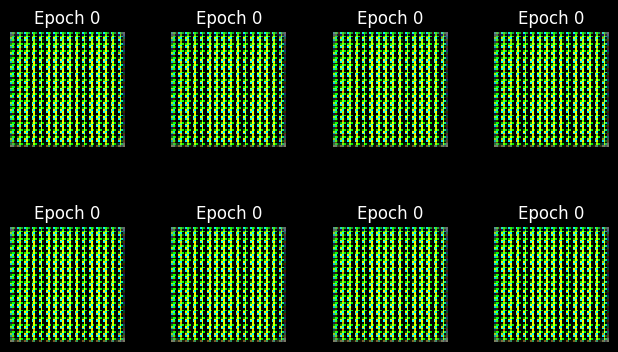

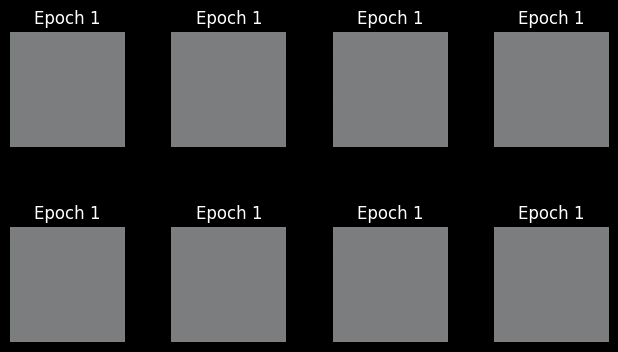

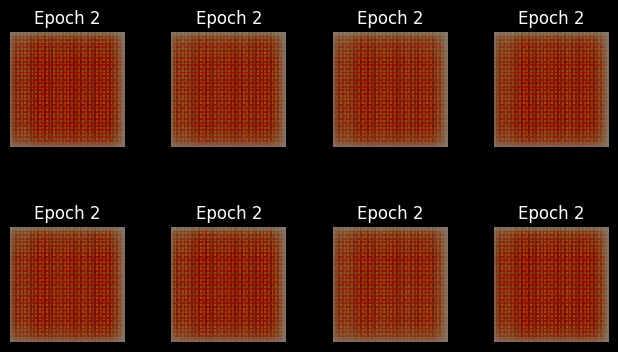

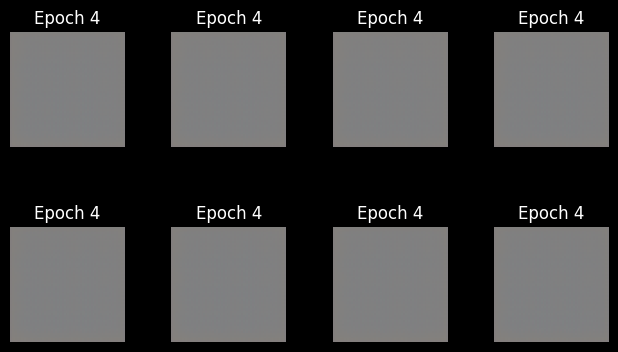

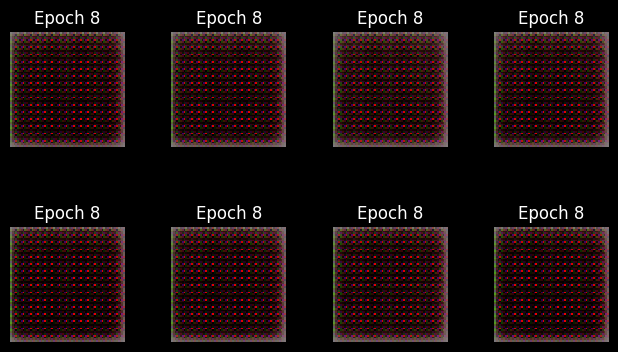

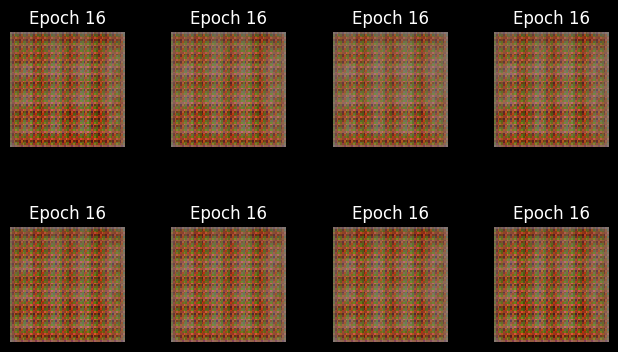

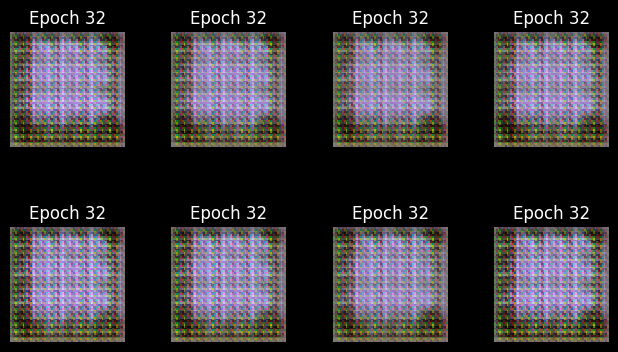

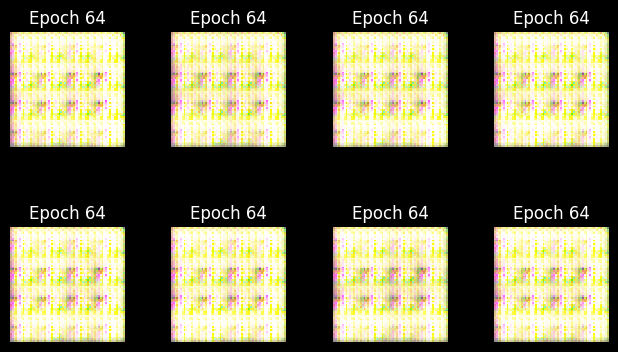

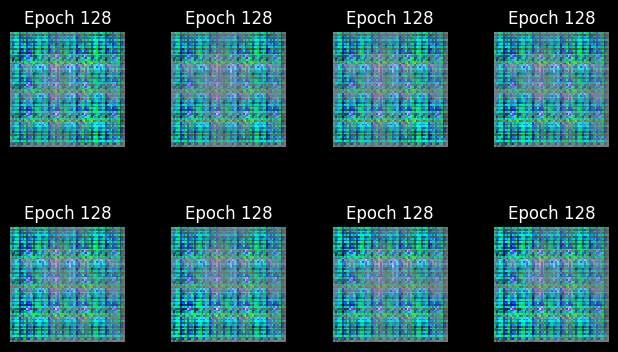

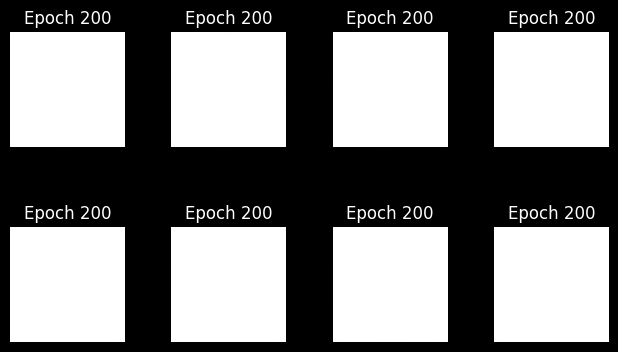

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/call.py", line 49, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/trainer.py", line 630, in _fit_impl
    self._run(model, ckpt_path=ckpt_path, weights_only=weights_only)
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/trainer.py", line 1079, in _run
    results = self._run_stage()
              ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/trainer.py", line 1123, in _run_stage
    self.fit_loop.run()
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py", line 217, in run
    self.advance()
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py", line 465, in advance
    self.epoch_loop.run(self._data_fetcher)
  File

TypeError: object of type 'NoneType' has no len()

In [20]:
trainer = pl.Trainer(max_epochs=300, devices=AVAIL_GPUS, log_every_n_steps=8)
trainer.fit(model, dm)
model.plot_imgs(show=True)

In [ ]:
# Example: Compute FID score for a trained model
# Uncomment and run after training to evaluate your model

model.eval()
test_dataloader = dm.test_dataloader()
fid_score = compute_fid_score(model, test_dataloader, n_samples=5000, device='cuda')
print(f"FID Score: {fid_score:.2f}")